In [1]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
tr_file = 'Data/train-data.dat'
tr_lbl_file = 'Data/train-label.dat'
t_file = 'Data/test-data.dat'
t_lbl_file = 'Data/test-label.dat'
labels_file = 'Data/labels.txt'
vocab_file = 'Data/vocabs.txt'

In [3]:
'''
def read_data_from_files_2(txt_file, data_file, labels_file):
    dictionary = {}
    data = []
    labels = []

    with open(txt_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            # splits the line into two values, the one before the comma (token) and the one after the comma (indx)           
            token, indx = line.split(', ')
            # create a dictionary of the form {indx: token}
            dictionary[int(indx)] = token

    
    with open(data_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            line_data = line.split(' ')
            # takes the first element of line_data by removing <> and taking only the element inside the brackets 
            # e.g. <215> results to 215 because 2,1,5 are the line_data[0][1], line_data[0][2] and line_data[0][3] respectively
            num_doc_sentences = int(line_data[0][1:-1])  
            doc_index = 1
            doc = ''
            
            # loop through the sentences of the document
            for i in range(num_doc_sentences):
                # takes the second element of line_data by removing <> and taking only the element inside the brackets
                num_sentence_tokens = int(line_data[doc_index][1:-1])
                doc_index += 1
                for i in range(doc_index, num_sentence_tokens + doc_index):
                    # take the indexes of the tokens of the sentence and find the corresponding words from vocaabulary
                    doc += dictionary[int(line_data[i])] + ' '
                doc_index += num_sentence_tokens
            data.append(doc)


    with open(labels_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            doc_labels = [int(output) for output in line.split(' ')]
            labels.append(doc_labels)

    return data, np.int8(labels)
'''    

In [4]:
def read_data_from_files(txt_file, data_file, labels_file):
    
    dictionary = {}
    data = []
    labels = []
    
    with open(txt_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            # splits the line into two values, the one before the comma (token) and the one after the comma (indx)           
            token, indx = line.split(', ')
            # create a dictionary of the form {indx: token}
            dictionary[int(indx)] = token
    
    with open(data_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            line_data = line.split(' ')
            # takes the first element of line_data by removing <> and taking only the element inside the brackets 
            # e.g. <215> results in 215 because 2,1,5 are the line_data[0][1], line_data[0][2], and line_data[0][3] respectively
            num_doc_sentences = int(line_data[0][1:-1])  
            doc_index = 1
            doc_sentences = []  # Store sentences of the document
            
            # Loop through the sentences of the document
            for i in range(num_doc_sentences):
                # takes the second element of line_data by removing <> and taking only the element inside the brackets
                num_sentence_tokens = int(line_data[doc_index][1:-1])
                doc_index += 1
                sentence = []
                
                for j in range(doc_index, num_sentence_tokens + doc_index):
                    # Take the indexes of the tokens of the sentence and find the corresponding words from the vocabulary
                    sentence.append(dictionary[int(line_data[j])])
                
                doc_index += num_sentence_tokens
                data.append(' '.join(sentence))
            
    with open(labels_file, 'r') as txtfile:
        lines = txtfile.read().splitlines()
        for line in lines:
            doc_labels = [int(output) for output in line.split(' ')]
            labels.append(doc_labels)

    return data, np.int8(labels)

In [5]:
train_docs, train_labels = read_data_from_files(vocab_file, tr_file, tr_lbl_file)
test_docs, test_labels = read_data_from_files(vocab_file, t_file, t_lbl_file)

In [6]:
print('\nFirst 3 train docs\n')
for i in range(3):
    print('{}:\t{}'.format(i, train_docs[i]))
print('\nExtracted {} documents'.format(len(train_docs)))

print('\nLabels of the first 3 docs')
print(train_labels[0:3])
train_labels.shape


First 3 train docs

0:	rubi rail helper demo more info auto complet
1:	see new helper action
2:	null length substr locat

Extracted 149925 documents

Labels of the first 3 docs
[[1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


(8251, 20)

In [7]:
print('\nExtracted {} documents'.format(len(test_docs)))


Extracted 73363 documents


In [8]:
tfidf_vectorizer = TfidfVectorizer(vocabulary=None)
train_inputs = tfidf_vectorizer.fit_transform(train_docs)
test_inputs = TfidfVectorizer(vocabulary=tfidf_vectorizer.get_feature_names_out()).fit_transform(test_docs)

train_inputs.shape, test_inputs.shape

((149925, 8520), (73363, 8520))

### Convert our multi-label problem to a binary classification problem

In [9]:
train_labels

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int8)

In [10]:
def multilabel_to_binary(labels):
    class_frequencies = np.sum(labels, axis=0)
    most_frequent_class = np.argmax(class_frequencies)

    binary_labels = np.zeros(labels.shape[0], dtype=int)
    binary_labels[labels[:, most_frequent_class] == 1] = 1

    return most_frequent_class, binary_labels

In [11]:
most_frequent_class, train_binary_labels = multilabel_to_binary(train_labels)
_, test_binary_labels = multilabel_to_binary(test_labels)

print('Most frequent class:',format(most_frequent_class))
print()
for i in range(10):
    print('Original: {}\tBinary: {}'.format(train_labels[i], train_binary_labels[i]))

Most frequent class: 2

Original: [1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]	Binary: 1
Original: [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]	Binary: 1
Original: [1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0]	Binary: 0
Original: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]	Binary: 1
Original: [1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]	Binary: 0
Original: [0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0]	Binary: 1
Original: [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]	Binary: 0


In [12]:
'''
from collections import Counter

# Perform clustering using K-means
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(train_inputs)

# Get cluster labels for each sentence
cluster_labels = kmeans.labels_

# Count the number of sentences in each cluster
cluster_counts = Counter(cluster_labels)

# Print the count of sentences in each cluster
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} sentences")
    
    
total_sentences = train_inputs.shape[0]
assigned_sentences = sum(cluster_counts.values())
if total_sentences == assigned_sentences:
    print("All sentences have been assigned to a cluster.")
else:
    print("Some sentences are not assigned to any cluster.")
'''

'\nfrom collections import Counter\n\n# Perform clustering using K-means\nkmeans = KMeans(n_clusters=5, random_state=42)\nkmeans.fit(train_inputs)\n\n# Get cluster labels for each sentence\ncluster_labels = kmeans.labels_\n\n# Count the number of sentences in each cluster\ncluster_counts = Counter(cluster_labels)\n\n# Print the count of sentences in each cluster\nfor cluster, count in cluster_counts.items():\n    print(f"Cluster {cluster}: {count} sentences")\n    \n    \ntotal_sentences = train_inputs.shape[0]\nassigned_sentences = sum(cluster_counts.values())\nif total_sentences == assigned_sentences:\n    print("All sentences have been assigned to a cluster.")\nelse:\n    print("Some sentences are not assigned to any cluster.")\n'

In [22]:
# Convert sparse matrix to dense matrix
#X_dense = train_inputs.toarray()

# Calculate WCSS for different values of n_clusters
wcss = []
max_clusters = 10  # Maximum number of clusters to consider
for n_clusters in range(3, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(train_inputs)
    wcss.append(kmeans.inertia_)



NameError: name 'plt' is not defined

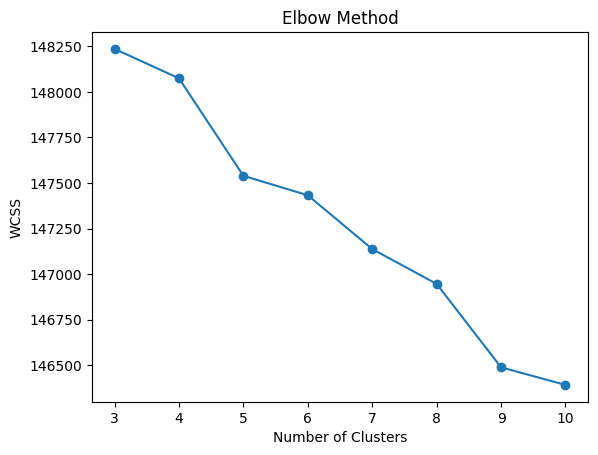

In [24]:
import matplotlib.pyplot as plt
# Plot the WCSS values
plt.plot(range(3, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()